In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
import pickle

# Goal:
The goal is to get some prediction for who will do well in the tour de france, just the GC for now, because that is easy.

# Scraper

Scrape pcs.com for different years.

- first get race names into list 
- then for each race get the years

In [2]:
PCS_URL = 'https://www.procyclingstats.com/'
RACES_URL = PCS_URL + 'races.php'
START_YEAR = 2000
END_YEAR = 2025
TOPN = 200 #topn to get 
PREV_YEARS = 3

REDO = False

data_filename = f'WT_races_top{TOPN}_{START_YEAR}-{END_YEAR}.json'

In [3]:
#first get the desired races names (only multiple stage races in 201 for reference) into a list

try:
    url = RACES_URL + "?year=2019&circuit=1&class=2.UWT&filter=Filter"

    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    li = soup.find("li", class_="more4")
    races = []
    for span in soup.find_all("span", class_='flag'):
        race = span.parent.find("a", href=True)['href'].split('/')[1]
        races.append(race)
    
#     races.remove('tour-of-guangxi')
#     races.remove('tour-of-turkey')
#     races.remove('renewi-tour')
    # races.append('la-route-d-occitanie')
except Exception as e:
    print(e)
    print("ERROR")
    print("COULD NOT SCRAPE RACES")
    print("SETTING TO DEFAULT")
    print("WARNING Might not be updated ok. for example renewi-tour/binckback-tour etc")
    races = ['tour-down-under', 'uae-tour', 'paris-nice', 'tirreno-adriatico', 'volta-a-catalunya', 'itzulia-basque-country', 'tour-de-romandie',
             'giro-d-italia', 'tour-of-california', 'dauphine', 'tour-de-suisse', 'tour-de-france', 'tour-de-pologne', 'benelux-tour', 'vuelta-a-espana']
    print()
print("Use these races:")
print(races)

Use these races:
['tour-down-under', 'uae-tour', 'paris-nice', 'tirreno-adriatico', 'volta-a-catalunya', 'itzulia-basque-country', 'tour-of-turkey', 'tour-de-romandie', 'giro-d-italia', 'tour-of-california', 'dauphine', 'tour-de-suisse', 'tour-de-france', 'tour-de-pologne', 'renewi-tour', 'vuelta-a-espana', 'tour-of-guangxi']


In [4]:
def get_race_topn(race, year, topn=TOPN):
    "Use BS to scrape pcs.com and get the topn for a race in a year"
    page = requests.get(PCS_URL+"race/"+race+"/"+str(year)+"/gc/") #only get GC
    race_soup = BeautifulSoup(page.content, "html.parser")
    i = 0
    top_l = []
    try:
        for entry in race_soup.find("th", class_="time_wonlost").find_next().find_all("a", href=True):
            if i >= topn:
                break
    #         print(entry['href'])
            if entry['href'][:5] == 'rider':
                top_l.append(entry.text)
                i += 1
    except AttributeError:
        return topn*[np.nan]
    return top_l

In [5]:
# For every race and year and put into a dictionary

if REDO:
    d = {}
    for year in range(START_YEAR, END_YEAR):
        print(year)
        d[year] = {}
        for race in races:
            print(race, end=' ')
            d[year][race] = get_race_topn(race, year, TOPN)

        print()

Now have a dictionary for every year and every race with the TOPN (default = 200), but need to modify this to be able to use it.

In [6]:
# Save data to json for later
import json
import os

#set to True if reload data from pcs.com

if not os.path.exists(data_filename) and REDO:
    with open(data_filename, "w") as write_file:
        json.dump(d, write_file, indent=4)
    print(f"Wrote data to {data_filename}")

In [7]:
#Load old data

with open(data_filename, "r") as infile:
    d = json.load(infile)
    d = {int(key): item for key,item in d.items()}
print(f"Loaded {data_filename} into d")

Loaded WT_races_top200_2000-2025.json into d


# Create dataframe
Now take the dictionary and create for every rider a column with their results in the previous races (say the current year, the previous year and two years ago, etc)

In [8]:
#Make pandas dataframe for each year

from collections import defaultdict

def check_names_len_append(names, topn):
    """
    if names is less than the topn you want
    apped with np.nan
    if it is larger just take the topn
    """
    n = len(names)
    if n < topn:
        for _ in range(topn - n):
            names.append(np.nan)
    elif n > topn:
        names = names[:topn]
    return names

def make_df_year(year, prev_years=2):
    """
    for each year make a dataframe with all names and their results in the races chosen above in 'races'
    with the results of this year, previosu year
    and two years ago
    
    THIS IS SO SLOW
    """

    dfs = []

    if prev_years < 1:
        raise ValueError(f"prev_years should be >= 1, is now {prev_years}")

    for prev_year in range(0, prev_years+1):
#         print(f"Getting {year-prev_year}")
        for key, item in d[year-prev_year].items():
            d[year-prev_year][key] = check_names_len_append(item, TOPN)
            
        df_year = pd.DataFrame(d[year-prev_year])
        if prev_year > 0:
            df_year = df_year.add_suffix(f'_prev{prev_year}')
        dfs.append(df_year)

    df_ = pd.concat(dfs)
    
    #ONly unique names
    series = pd.Series(np.ravel(df_.to_numpy())).unique()
    codes, uniques = pd.factorize(series)
    df = pd.concat(dfs, axis=1, ignore_index=False)
    
    
# #     #the slow part starts here
# #     print('here slowness')
    dd = defaultdict(list)
    for name in uniques:
        dd['name'].append(name)
        for race in df_.columns: 
            try:
                idx = df.index[df[race] == name][0] + 1
#                 idx = int(df[race].loc[df[race] == name].index[0]+1)
            except:
                idx = np.nan
            dd[race].append(idx)
        dd['year'].append(year)
#     print(".")
    df = pd.DataFrame(dd)
    df = df.reset_index()
    df = df.set_index('name') 
    print("...done")
    return df

In [9]:
#Here put everything in one database and split into train and test

if REDO:
    dfs = []

    for year in range(START_YEAR+PREV_YEARS, END_YEAR):
        print(year)
        df = make_df_year(year, PREV_YEARS)
        df['top10'] = df['tour-de-france'].apply(lambda x: 1 if x <= 10 else 0)
        df['top5'] = df['tour-de-france'].apply(lambda x: 1 if x <= 5 else 0)
        df['top3'] = df['tour-de-france'].apply(lambda x: 1 if x <= 3 else 0)
        df['top1'] = df['tour-de-france'].apply(lambda x: 1 if x == 1 else 0)
        dfs.append(df)

    df = pd.concat(dfs)

    df.to_pickle('df_data.pl')
    test_mask = df['year'].isin(np.random.choice(range(START_YEAR+PREV_YEARS, END_YEAR-2), 4, replace=False))
    df_test = df.loc[test_mask]
    df_train = df.loc[~test_mask]
    df_train.to_pickle('train.pl')
    df_test.to_pickle('test.pl')

In [10]:
#Load these again if you didn't REDO
df_train = pd.read_pickle('train.pl')
df_test = pd.read_pickle('test.pl')

In [11]:
#only take those that actually did the TDF
df_train = df_train.loc[~df_train['tour-de-france'].isna()]
df_test = df_test.loc[~df_test['tour-de-france'].isna()]

## Have a look:

Notice that if a rider did not finish that race the result is NaN. Should do something with the NaNs...

In [12]:
df_train.head(5)

,index,tour-down-under,uae-tour,paris-nice,tirreno-adriatico,volta-a-catalunya,itzulia-basque-country,tour-of-turkey,tour-de-romandie,giro-d-italia,...,tour-de-france_prev3,tour-de-pologne_prev3,renewi-tour_prev3,vuelta-a-espana_prev3,tour-of-guangxi_prev3,year,top10,top5,top3,top1
name,,,,,,,,,,,,,,,,,,,,,
ASTARLOZA Mikel,0,1.0,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2003,0,0,0,0
VINOKOUROV Alexandre,1,NaN,NaN,1.0,NaN,NaN,10.0,NaN,NaN,NaN,...,15.0,NaN,NaN,28.0,NaN,2003,1,1,1,0
MAYO Iban,4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2003,1,0,0,0
HAMILTON Tyler,6,NaN,NaN,40.0,NaN,NaN,2.0,NaN,1.0,NaN,...,25.0,NaN,NaN,NaN,NaN,2003,1,1,0,0
SIMONI Gilberto,7,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,29.0,NaN,2003,0,0,0,0


In [13]:
#Load some sklearn models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, precision_score
# from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# from sklearn.ensemble import AdaBoostClassifier
# from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
import pickle

# Classifier
The classifier should predict if the rider ends in the top 10 of this years tour-de-france (or the top 5 or top 3 or even top 1). This is kinda tricky, because it is much more likely that a rider will NOT end up in the top 10. So the data set is unbalanced. 

Did a Gridsearch based on the precision (PPV) (which is the True Positives/Total predicted positives), because I want to know if the model predicts that a rider ends up in the topN, how likely is is that it actually does. So precision should be high.

ALso check the False negative rate (FNR=False negetaive/all positives) which should be low

top1
ROC 0.9706591639871383
PPV 1.00
FNR  0.75
HistGradientBoostingClassifier(max_bins=100, max_depth=3, max_leaf_nodes=4,
                               min_samples_leaf=5)
top3
ROC 0.9265743756786102
PPV 0.50
FNR  0.83
HistGradientBoostingClassifier(max_bins=100, max_depth=2, max_leaf_nodes=4,
                               min_samples_leaf=5)
top5
ROC 0.9379950495049505
PPV 0.70
FNR  0.65
HistGradientBoostingClassifier(max_bins=100, max_depth=3, max_leaf_nodes=4,
                               min_samples_leaf=5)
top10
ROC 0.9419368600682595
PPV 0.56
FNR  0.65
HistGradientBoostingClassifier(max_bins=100, max_depth=2, max_leaf_nodes=3,
                               min_samples_leaf=5)


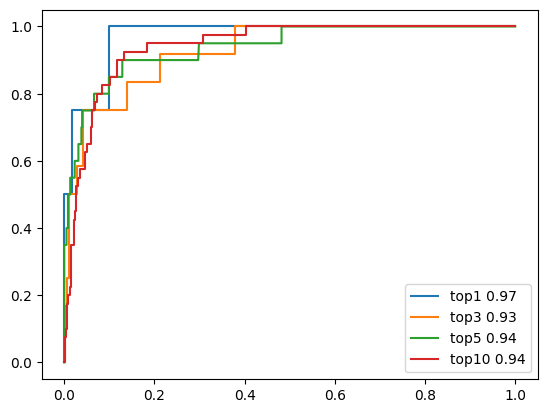

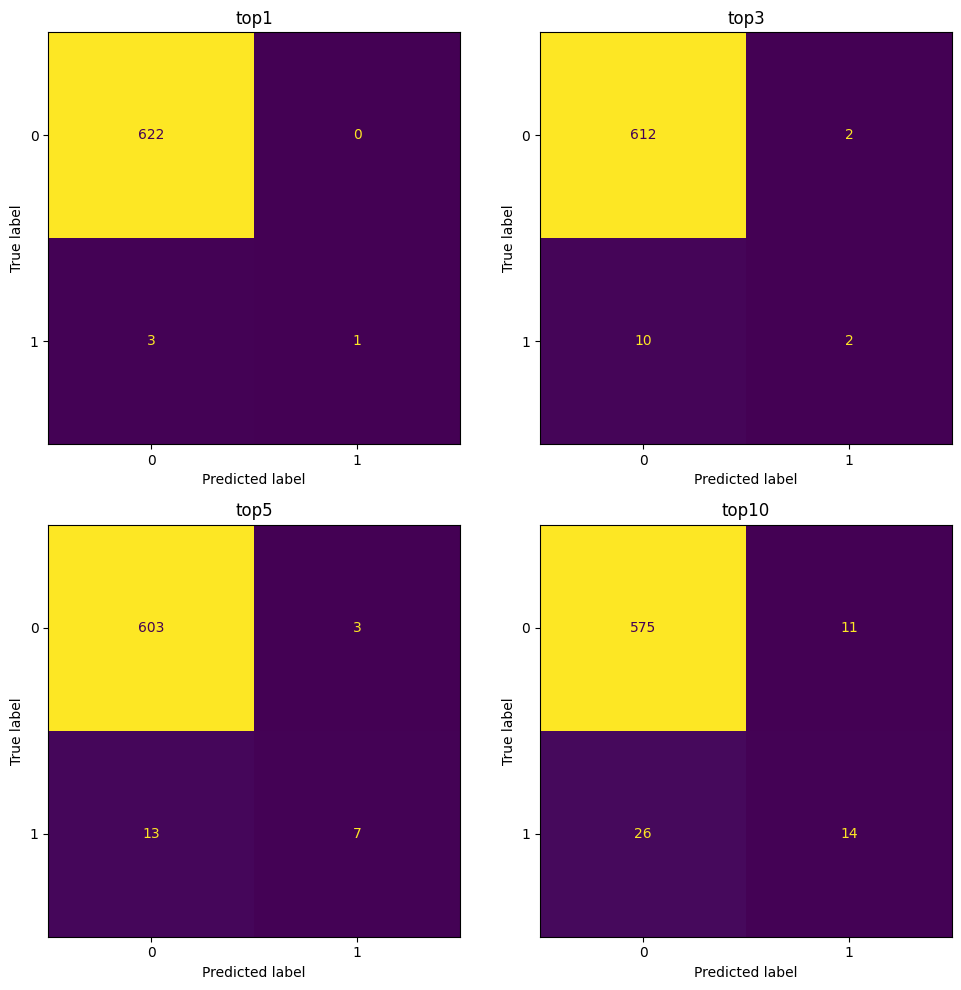

In [14]:
f, ax = plt.subplots(1)

#Drop the tour-de-france results
drops = ['index', 'tour-de-france', 'year', 'top10', 'top5', 'top3', 'top1']

#Just take the NaNs and use a model that can handle them like histgradientboostinclassfier
X_train = df_train.drop(drops, axis=1)#.fillna(1000)
X_test = df_test.drop(drops, axis=1)#.fillna(1000)
# X_train[X_train > 30] = 30
# X_test[X_test > 30] = 30
# X_max = np.max(X_train, axis=0)
# X_min = np.min(X_train, axis=0)
# X_train = (X_train - X_max)/np.maximum(1, (X_max - X_min))
# X_test = (X_test - X_max)/np.maximum(1, (X_max - X_min))
clfs = {}

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
df_test_copy = df_test.copy(deep=True)
for label, ax_ in zip(['top1', 'top3', 'top5', 'top10'], axes):
    print(label)
    y_train = df_train[label]
    y_test = df_test[label]
    X_resampled, y_resampled = X_train, y_train #SMOTE().fit_resample(X_train, y_train)
    param_grid = {'max_depth': [2, 3], 'max_leaf_nodes': [3, 4], 'min_samples_leaf': [5], 'max_bins': [100]}
    base_est = HistGradientBoostingClassifier()
    
    #Change this to some other scoring to see what happens, not much?
    clf = GridSearchCV(base_est, param_grid, scoring='roc_auc', n_jobs=2)
#     clf = GridSearchCV(base_est, param_grid, scoring='balanced_accuracy', n_jobs=2)
    clf.fit(X_resampled, y_resampled)
    clfs[label] = clf
    n = len(y_test)
    y_pred = clf.predict(X_test)
#     print('all')
    y_pred = clf.predict(X_test)
    
    print("ROC", clf.score(X_test, y_test))
#     print("Precision: ", clf.score(X_test, y_test), "Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))

    print(f"PPV {precision_score(y_test, y_pred):.2f}")
    # conf = plot_confusion_matrix(clf, X_test, y_test, ax=ax_, colorbar=False)
    # cm = confusion_matrix()
    conf = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax_, colorbar=False)
    conf_matrix = conf.confusion_matrix
    NPV = conf_matrix[1][0]/conf_matrix[1].sum()
    print(f"FNR  {NPV:.2f}")

    df_test_copy[label+"_pred"] = y_pred
    prob_y_pred = clf.predict_proba(X_test)
    df_test_copy[label+"prob"] = prob_y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, prob_y_pred[:, 1])
    ax.plot(fpr, tpr, label=label+f" {roc_auc_score(y_test, prob_y_pred[:, 1]):.2f}")
    ax_.set_title(label)
    print(clf.best_estimator_)
    with open(label+"clf.pl", 'wb') as outfile:
        pickle.dump(clf.best_estimator_, outfile)


fig.tight_layout()
ax.legend()

For the top 10 the precision is about 0.7, so in 70% of the cases where the model predicts top 10, it actually will be a top 10, not so bad...

ON the other hand, the FNR is 65%, so a lot of riders that will make top10 are missed.

## Some tests:

In [25]:
year = np.random.choice(df_test_copy['year'].unique())
print(year)
# year = 2023

2019


In [26]:
df_test_copy.query(f'year == {year}').sort_values('top10prob', ascending=False)[['top10prob', 'top5prob', 'top3prob', 'top1prob', 'tour-de-france']].iloc[:20]

,top10prob,top5prob,top3prob,top1prob,tour-de-france
name,,,,,
MARTIN Dan,0.923237,0.507739,0.397379,0.000048,18.0
QUINTANA Nairo,0.908480,0.366871,0.053584,0.000003,8.0
BARDET Romain,0.860708,0.540427,0.125889,0.000007,15.0
BUCHMANN Emanuel,0.832035,0.180089,0.025658,0.000303,4.0
MAS Enric,0.670834,0.279885,0.012537,0.000915,22.0
VALVERDE Alejandro,0.639307,0.054001,0.141221,0.000301,9.0
LANDA Mikel,0.565750,0.187168,0.083635,0.000014,6.0
THOMAS Geraint,0.551941,0.667481,0.891422,0.000048,2.0
BERNAL Egan,0.315166,0.124748,0.159261,0.000057,1.0


In [27]:
df_test_copy.query(f'year == {year}').sort_values('tour-de-france')[['year', 'top10_pred', 'top10prob']].iloc[:20]

,year,top10_pred,top10prob
name,,,
BERNAL Egan,2019,0,0.315166
THOMAS Geraint,2019,1,0.551941
KRUIJSWIJK Steven,2019,0,0.287420
BUCHMANN Emanuel,2019,1,0.832035
ALAPHILIPPE Julian,2019,0,0.022512
LANDA Mikel,2019,1,0.565750
URÁN Rigoberto,2019,0,0.209509
QUINTANA Nairo,2019,1,0.908480
VALVERDE Alejandro,2019,1,0.639307


# This year TDF

2023 now, let's see...

In [28]:
df_ = make_df_year(2024, PREV_YEARS)

...done


In [44]:
drops = ['index', 'tour-de-france', 'year']
X = df_.drop(drops, axis=1)

In [62]:
X[X.isnull().all()]

tour-down-under          False
uae-tour                 False
paris-nice               False
tirreno-adriatico        False
volta-a-catalunya        False
                         ...  
tour-de-france_prev3     False
tour-de-pologne_prev3    False
renewi-tour_prev3        False
vuelta-a-espana_prev3    False
tour-of-guangxi_prev3     True
Length: 67, dtype: bool

In [45]:
import pickle
for label in ["top1", "top3", "top5", "top10"]:
    with open(label+"clf.pl", 'rb') as infile:
        clf = pickle.load(infile)
    
    df_[label+"_pred"] = clf.predict(X)
    prob_y_pred = clf.predict_proba(X)
    df_[label+"prob"] = prob_y_pred[:, 1]


In [47]:
dfs = []
for tree in clf._predictors:
    df = pd.DataFrame(tree[0].nodes)
    dfs.append(df)
    
df = pd.concat(dfs)

In [53]:
df_.count()

index                1321
tour-down-under       130
uae-tour              129
paris-nice            103
tirreno-adriatico     125
                     ... 
top3prob             1321
top5_pred            1321
top5prob             1321
top10_pred           1321
top10prob            1321
Length: 78, dtype: int64

In [51]:
df.groupby('feature_idx')['gain'].sum().sort_values(ascending=False).shape

(43,)

## Most likely TDF top 10 finishers

In [24]:
df_top10_2024 = df_.sort_values('top10prob', ascending=False)[['top10prob', 'top5prob', 'top3prob', 'top1prob']]
df_top10_2024.head(20)

,top10prob,top5prob,top3prob,top1prob
name,,,,
ROGLIČ Primož,0.967272,0.710921,0.508893,0.487512
BILBAO Pello,0.882116,0.080054,0.087005,0.000025
LANDA Mikel,0.872383,0.142281,0.009844,0.000004
HINDLEY Jai,0.864238,0.237603,0.093291,0.001632
VINGEGAARD Jonas,0.763896,0.893640,0.597581,0.019590
VLASOV Aleksandr,0.754030,0.202395,0.201482,0.000086
YATES Adam,0.754013,0.063430,0.160002,0.000017
RODRÍGUEZ Carlos,0.707755,0.637841,0.028266,0.000369
O'CONNOR Ben,0.668467,0.053412,0.097458,0.000103


## Comments:
- The top3 or 5 probabibly can be larger than the top10 prob? (Weird but they are different classifiers...), thank MK
- Some people are not even competing in the tdf (woops)
- The top1 prob for pogi is crazy high
- 